# SDE for generative modeling

The notebook implements generative modeling with an stochastic differential equation (SDE) for a latent variable $x_t$, $t\in [0,1]$ using the following three steps:
\begin{align*}
x_0 & \sim p(x_0) \\
dx & = f(x,t)\, dt + \sigma(x,t) \, dW, \hspace{15mm}  t \in [0,1] \\
y & \sim p(y|x_1) ,
\end{align*}
where $dW \sim N(0,dt)$ is Gaussian noise with variance $dt$.

In the notebook we will simulate data from a known one dimensional distribution. We will use a generated training set to learn the SDE drift $f(x,t)$ and diffusion coefficient $\sigma(x,t$). Both are parameterized as neural networks.

We can compute the log likelihood lower bound (evidence lower bound, ELBO) $\log p(y) \geq \mathrm{ELBO}(y)$ for this setup and this is done in the code.

## Imports

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import laplace
from torchsummary import summary

## GPU

In [2]:
# GPU
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print('GPU State:', device)

GPU State: cuda:0


In [3]:
import torch
import numpy as np
import random

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

set_seed(42)

## Data generation class

In [4]:
import torch
import numpy as np

class TrainingSetWithLogLikelihood:
    def __init__(self, distribution, params):
        self.distribution = distribution
        self.params = params

    def generate_training_data(self, n_samples=5000):
        """
        Generate a training dataset and compute the true expected log likelihood for this data.
        :return: training_data (tensor), expected_log_likelihood (float)
        """
        if self.distribution == 'laplace_mixture':
            k = self.params['k']  # Number of components
            spacing = self.params['spacing']  # spacing between means
            scale = self.params['scale']  # Laplace scale (spread)
            means = np.arange(-spacing * (k - 1) / 2, spacing * ( (k - 1) / 2 + 1), spacing)

            data = self.generate_laplace_mixture(n_samples, means, scale)

            # Compute the log likelihood for the Laplace mixture distribution
            expected_log_likelihood = self.laplace_mixture_log_likelihood(data, means, scale)

        elif self.distribution == 'laplace':
            loc, scale = self.params['loc'], self.params['scale']
            data = torch.tensor(np.random.laplace(loc=loc, scale=scale, size=(n_samples, 1)), dtype=torch.float32)

            # Compute the log likelihood for the Laplace distribution
            expected_log_likelihood = self.laplace_log_likelihood(data, loc, scale)

        elif self.distribution == 'gaussian':
            mean, std = self.params['mean'], self.params['std']
            data = torch.tensor(np.random.normal(loc=mean, scale=std, size=(n_samples, 1)), dtype=torch.float32)

            # Compute the log likelihood for the Gaussian distribution
            expected_log_likelihood = self.gaussian_log_likelihood(data, mean, std)

        else:
            raise ValueError(f"Unsupported distribution: {self.distribution}")

        return data, expected_log_likelihood

    def generate_laplace_mixture(self, n_samples, means, scale):
        """
        Generate data from a mixture of Laplace distributions.
        :param n_samples: Number of samples to generate
        :param k: Number of components (each side of 0)
        :param scale: Scale parameter for the Laplace distribution
        :return: Generated data (tensor)
        """
        n_components = len(means)
        proportions = np.ones(n_components) / n_components  # Uniform mixture
        data = []

        for _ in range(n_samples):
            mean = np.random.choice(means, p=proportions)  # Select a component
            sample = np.random.laplace(loc=mean, scale=scale)  # Generate a sample
            data.append(sample)

        return torch.tensor(data, dtype=torch.float32).unsqueeze(1)

    def laplace_mixture_log_likelihood(self, data, means, scale):
        """
        Compute the log likelihood for a mixture of Laplace distributions.
        :param data: Training data tensor
        :param means: Means of the Laplace components
        :param scale: Scale parameter of the Laplace components
        :return: Expected log likelihood (float)
        """
        log_likelihoods = []
        for mean in means:
            log_likelihood = -torch.abs(data - mean) / scale - torch.log(2 * scale)
            log_likelihoods.append(log_likelihood)

        # Convert to a tensor and compute the log of the sum across components
        log_likelihoods = torch.stack(log_likelihoods, dim=1)  # Shape: (n_samples, n_components)
        mixture_log_likelihood = torch.logsumexp(log_likelihoods, dim=1) - np.log(len(means))

        return mixture_log_likelihood.mean().item()

    def laplace_log_likelihood(self, data, loc, scale):
        """
        Compute the log likelihood for the Laplace distribution.
        :param data: Training data tensor
        :param loc: Location (mean) parameter of the Laplace distribution
        :param scale: Scale parameter of the Laplace distribution
        :return: Expected log likelihood (float)
        """
        log_likelihood = -torch.abs(data - loc) / scale - torch.log(2 * scale)
        return log_likelihood.mean().item()

    def gaussian_log_likelihood(self, data, mean, std):
        """
        Compute the log likelihood for the Gaussian distribution.
        :param data: Training data tensor
        :param mean: Mean of the Gaussian distribution
        :param std: Standard deviation of the Gaussian distribution
        :return: Expected log likelihood (float)
        """
        log_likelihood = -0.5 * ((data - mean)**2 / std**2) - 0.5 * torch.log(2 * torch.pi * std**2)
        return log_likelihood.mean().item()


## Prior and likelihood classes

In [5]:
# Unified prior interface for both distribution and log probability
class Prior:
    def __init__(self, sample_func, log_prob_func):
        self.sample_func = sample_func
        self.log_prob_func = log_prob_func

    def sample(self, n_samples):
        return self.sample_func(n_samples)

    def log_prob(self, x):
        return self.log_prob_func(x)

# Gaussian prior distribution
def gaussian_sample(n_samples):
    return torch.tensor(np.random.normal(loc=0, scale=1, size=(n_samples, 1)), dtype=torch.float32)

# Laplace prior distribution
def laplace_sample(n_samples):
    return torch.tensor(np.random.laplace(loc=0, scale=1, size=(n_samples, 1)), dtype=torch.float32)

# Gaussian log probability for prior (mean=0, variance=1)
def gaussian_log_pdf(x):
    return -0.5 * torch.log(torch.tensor(2 * np.pi)) - 0.5 * x**2

# Laplace log probability for prior (mean=0, scale=1)
def laplace_log_pdf(x):
    return -torch.abs(x) - torch.log(torch.tensor(2.0))

class Likelihood(nn.Module):
    def __init__(self, beta):
        super(Likelihood, self).__init__()
        self.beta = beta

    def log_prob(self, y, x):
        """
        Compute the log likelihood term based on y and x
        :param y: Observed data points y
        :param x: Generated data points x(1) from the variational SDE
        :return: Log likelihood for the mini-batch
        """
        beta = self.beta()
        variance = beta**2  # Variance for the Gaussian likelihood
        log_likelihood = -0.5 * ((y - x) ** 2 / variance + torch.log(2 * np.pi * variance))
        return log_likelihood

    def sample(self, x):
        """
        Sample from the Gaussian likelihood distribution.
        :param x: Mean output (from the variational SDE at t=1)
        :return: Generated samples with mean x and variance epsilon^2
        """
        # Ensure the number of samples matches the dimension of x
        beta = self.beta()
        return x + torch.randn_like(x) * beta

## Drift, diffusion and variational network components

In [6]:
# Define the drift network f(x, t)
class DriftNetwork(nn.Module):
    def __init__(self):
        super(DriftNetwork, self).__init__()
        self.net = nn.Sequential(
            #nn.Linear(2,1)
            nn.Linear(2, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 1)
        )

    def forward(self, x, t):
        x_t = torch.cat([x, t], dim=-1)
        return self.net(x_t)

# Define the diffusion network sigma(x, t)
class DiffusionNetwork(nn.Module):
    def __init__(self):
        super(DiffusionNetwork, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 1)
        )

    def forward(self, x, t):
        x_t = torch.cat([x, t], dim=-1)  # Concatenate along the last dimension
        return nn.Softplus()(self.net(x_t))

class DiffusionNetwork0(nn.Module):
    def __init__(self, sigma=1e-2):
        super(DiffusionNetwork0, self).__init__()
        self.sigma = sigma

    def forward(self, x, t):
        #return self.sigma.expand_as(plt.xticks)
        sigma_tensor = torch.tensor(self.sigma)
        return sigma_tensor.expand_as(x)



# Define the alpha(y, t) network for variational mean
class AlphaNetwork(nn.Module):
    def __init__(self):
        super(AlphaNetwork, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 1)
        )

    def forward(self, y, t):
        y_t = torch.cat([y, t], dim=-1)  # Concatenate along the last dimension
        return t * y + (1-t) * self.net(y_t) # changed from self.net(y_t)


class AlphaNetwork0(nn.Module):
    def __init__(self):
        super(AlphaNetwork0, self).__init__()

    def forward(self, y, t):
        return t * y

class AlphaNetwork1(nn.Module):
    def __init__(self):
        super(AlphaNetwork1, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 1)
        )

    def forward(self, y, t):
        # Simple t dependence giving straight lines in backward sample paths
        return t * y + (1-t) * self.net(y)

# Define the beta(y, t) network for variational standard deviation
class BetaNetwork(nn.Module):
    def __init__(self, beta):
        super(BetaNetwork, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 1)
        )
        self.beta = beta

    def forward(self, y, t):
        beta = self.beta()
        y_t = torch.cat([y, t], dim=-1)  # Concatenate along the last dimension
        return t * beta + (1-t) * nn.Softplus()(self.net(y_t)) # nn.Softplus()(self.net(y_t))

class BetaNetwork0(nn.Module):
    def __init__(self, beta=0.01):
        super(BetaNetwork0, self).__init__()
        self.beta = beta

    def forward(self, y, t):
        t = t.expand_as(y)
        return self.beta() * t + (1-t)

# Define a shared log_beta parameter that can be used in Likelihood and BetaNetwork
class Beta(nn.Module):
    def __init__(self, initial_beta=1e-1, trainable=True):
        super(Beta, self).__init__()
        if trainable:
            # Learnable log_beta parameter
            self.log_beta = nn.Parameter(torch.log(torch.tensor(initial_beta)))
        else:
            # Fixed log_beta as a constant tensor
            self.register_buffer("log_beta", torch.log(torch.tensor(initial_beta)))

    def forward(self):
        # Compute beta from log_beta (ensure non-negativity)
        return torch.exp(self.log_beta) # alternatively nn.functional.softplus(self.log_beta)

## Variational distribution class

In [7]:
class Variational(nn.Module):
    # So far only implemented for Gaussian
    def __init__(self, alpha_net, beta_net, y, t):
        super(Variational, self).__init__()

        # Register alpha_net and beta_net as submodules
        self.alpha_net = alpha_net
        self.beta_net = beta_net

        # data
        self.y = y
        self.t = t

        self._forward_result = None # cached results so we only have to do the forward pass once

    def _compute_forward(self):
        """Compute the forward pass and cache the result."""
        if self._forward_result is None:  # Compute only if not already computed
            self._forward_result = self.forward(self.y, self.t)
        return self._forward_result

    def forward(self, y, t):
        alpha = self.alpha_net(y, t)
        beta = self.beta_net(y, t)
        return alpha, beta

    def sample(self):
        alpha, beta = self._compute_forward()
        epsilon = torch.randn_like(alpha)
        return alpha + beta * epsilon

    def log_prob(self, x):
        alpha, beta = self._compute_forward()
        log_prob = -0.5 * (((x - alpha) / beta) ** 2 + torch.log(2 * np.pi * beta**2))
        return log_prob


    def drift(self, x, mode="ode", sigma_net=None):
        """
        Compute the drift term for the variational distribution.
        mode can be "ode", "sde" or "backward sde".
        self.t.requires_grad = True should be set before compute forward step."""

        alpha, beta = self._compute_forward()

        # Compute the partial derivatives w.r.t. t
        d_alpha_dt = torch.autograd.grad(alpha, self.t, grad_outputs=torch.ones_like(alpha), create_graph=True)[0]
        d_beta_dt = torch.autograd.grad(beta, self.t, grad_outputs=torch.ones_like(beta), create_graph=True)[0]

        drift_term = (d_beta_dt * (x - alpha) / beta) + d_alpha_dt

        if mode == "ode":
            return drift_term

        # Compute sigma^2 and the partial derivative of sigma^2 with respect to x
        sigma = sigma_net(x, self.t)
        sigma_squared = sigma**2
        d_sigma2_dx = torch.autograd.grad(sigma_squared, x, grad_outputs=torch.ones_like(sigma_squared), create_graph=True)[0]

        # Score term: (partial log q / partial x) for q(x, t|y) = N(x | alpha, beta^2)
        score = -(x - alpha) / beta**2

        # Calculate drift g(x, y, t)
        if mode == "backward sde":
            drift_term -= d_sigma2_dx / 2 + (sigma_squared / 2) * score
        else: # "sde"
            drift_term += d_sigma2_dx / 2 + (sigma_squared / 2) * score

        return drift_term, sigma_squared

## Forward and backward path generation and visualization

In [8]:
import torch

class ForwardPath:
    def __init__(self, mode="ode", f_net=None, sigma_net=None, prior=None, likelihood_func=None):
        """
        Initialize the ForwardPath object to solve the forward path from t=0 to t=1.

        :param mode: Mode to select ("ode" or "sde")
        :param f_net: Neural network defining the ODE drift or SDE drift
        :param sigma_net: Neural network defining the diffusion term (used in SDE)
        :param prior: Prior distribution object with a `sample` method for t=0 sampling
        :param likelihood_func: Likelihood function object y ~ p(y|x_1). If None the continuous flow formulation is used with y = x_1.
        """
        assert mode in ["ode", "sde"], "Invalid mode selected."
        self.mode = mode
        self.f_net = f_net
        self.sigma_net = sigma_net
        self.prior = prior
        self.likelihood_func = likelihood_func

    def sample_prior(self, n_samples):
        """Sample from the prior distribution at t=0."""
        return self.prior.sample(n_samples)

    def integrate(self, x0, t_grid):
        """
        Integrate the forward path from t=0 to t=1 based on the chosen mode.

        :param x0: Initial samples from the prior distribution at t=0
        :param t_grid: Time grid for integration
        :return: Path of samples from t=0 to t=1

        Note: So far only implemented for Euler-Maruyama integration
        """
        x_t = x0
        paths = [x0]

        # Calculate dt based on t_grid spacing
        dt = t_grid[1] - t_grid[0]

        for t in t_grid[:-1]:  # Integrate from t=0 to t=1

            t = t.expand_as(x_t)

            if self.mode == "ode":
                drift = self.f_net(x_t, t) #torch.tensor([t]))
                x_t = x_t + drift * dt

            elif self.mode == "sde":
                drift = self.f_net(x_t, t) #torch.tensor([t]))
                sigma = self.sigma_net(x_t, t) #torch.tensor([t]))
                noise = torch.randn_like(x_t) * torch.sqrt(dt)
                x_t = x_t + drift * dt + sigma * noise

            paths.append(x_t)

        return torch.stack(paths)

    def sample_data(self, x_1):
        """
        Sample data based on the final x_1 in one of two ways:
        :param x_1: The final samples at t=1
        :param use_likelihood: If True, sample from p(y|x_1) using the likelihood function. If False, set y=x_1.
        :return: Samples y based on the final distribution

        Note: So far only implemented for Euler-Maruyama integration
       """
        if self.likelihood_func is not None:
            return self.likelihood_func.sample(x_1)  # Sample y ~ p(y | x_1)
        else:
            return x_1  # Continuous flow case where y = x_1

    def sample(self, n_samples, t_grid):

        # Sample initial points from the prior
        x0 = self.sample_prior(n_samples)

        # Integrate the forward path
        path = self.integrate(x0, t_grid)

        # Sample data y using the likelihood function
        y = self.sample_data(path[-1])

        return y, path, x0

class BackwardPath:
    def __init__(self, mode="ode", start="direct", f_net=None, alpha_net=None, beta_net=None, sigma_net=None, likelihood_func=None):
        """
        Initialize the BackwardPath object to solve the path from t=1 to t=0.
        Uses either ODE model ("f_net") or variational distribution ("ode" and "backward sde").

        :param mode: Mode to select ("f_net", "ode", "backward sde").
        :param f_net: Neural network defining the drift for straight ODE in "f_net" mode
        :param alpha_et: Neural network defining the mean for variational in "ode" and "backward sde" mode
        :param beta_net: Neural network defining the standard deviation for variational in "ode" and "backward_sde" mode
        :param sigma_net: Neural network defining the diffusion term (used in SDE cases) in "backward sde" mode
        :param likelihood_func: Likelihood function object. If not None then x1 ~ q_1(x_1|y)) else the continuous flow formulation is used x1 = y.
        """
        assert mode in ["f_net", "ode", "backward sde"], "Invalid mode selected."
        self.mode = mode
        self.f_net = f_net
        self.alpha_net = alpha_net
        self.beta_net = beta_net
        self.sigma_net = sigma_net
        self.likelihood_func = likelihood_func

    def sample_starting_point(self, y):
        """Define x1 either as y or by sampling from q_1(x_1|y)."""
        if self.likelihood_func is None:
            return y
        else: # use variational
            q_x1_given_y = Variational(self.alpha_net, self.beta_net, y, torch.full(y.size(), 1.0))
            return q_x1_given_y.sample()

    def integrate(self, x1, t_grid, y=None):
        """
        Integrate the backward path from t=1 to t=0 based on the chosen mode.

        :param x1: Starting samples at t=1 (either y directly or sampled from q(x,1|y))
        :param t_grid: Time grid for integration
        :param y: Observed data for calculating score term when using q(x,t|y)
        :return: Path of samples from t=1 to t=0
        """
        x_t = x1
        paths = [x1]

        # Calculate dt based on t_grid spacing and reverse for backward integration
        dt = -(t_grid[1] - t_grid[0])

        for t in reversed(t_grid[1:]):  # Integrate backward from t=1 to t=0

            t = t.expand_as(x_t)

            # Compute the drift based on the specified mode
            if self.mode == "ode":
                drift = self.f_net(x_t, t)
            else: # use variational
                t.requires_grad = True # drift calculation requires
                q_xt_given_y = Variational(self.alpha_net, self.beta_net, y, t)
                drift, _ = q_xt_given_y.drift(x_t, mode=self.mode, sigma_net=self.sigma_net)

            x_t = x_t + drift * dt

            if self.mode == "backward sde":
                dW = torch.randn_like(x_t) * torch.sqrt(-dt)  # Simulate Brownian motion increment
                x_t = x_t + self.sigma_net(x_t, t) * dW

            paths.append(x_t)

        # Reverse the paths to go from t=0 to t=1
        return torch.stack(paths[::-1])

    def sample(self, y, t_grid):

      # Sample starting points from data y
      x1 = self.sample_starting_point(y)

      # Integrate the backward path
      path = self.integrate(x1, t_grid, y=y)

      # Extract prior samples x0
      x0 = path[0]

      return x0, path, x1

def visualize_paths_and_marginals(data, t_grid, backward_path, forward_path):
    fig = plt.figure(figsize=(12, 8))

    # 3D plot
    ax = fig.add_subplot(111, projection='3d')

    # Define the x-range
    x_range = (-10, 10)

    # Plot the training data density at t=1 as a histogram
    hist_vals, bin_edges = np.histogram(data.detach().numpy(), bins=50, range=x_range, density=True)
    bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
    ax.plot(np.ones_like(bin_centers), bin_centers, hist_vals, color='b', lw=2, label="Training Data (t=1)")

    # number of samples
    n_samples = data.shape[0]

    # get backward paths
    x0_backward, backward_paths, x1 = backward_path.sample(data, t_grid)

    # Plot the backward paths (from x(1) to x(0)) - max 10
    for i in range(min(10,n_samples)):
        ax.plot(t_grid, backward_paths[:, i].detach().numpy().squeeze(), np.zeros_like(t_grid), lw=1, color='r', alpha=0.7, label="Backward Paths (dt<0)" if i == 0 else "")

    # get forward paths
    y_samples, forward_paths, x0 = forward_path.sample(n_samples, t_grid)

    # Plot the forward paths (from x(0) to x(1)) - max 10
    for i in range(min(10,n_samples)):
        ax.plot(t_grid, forward_paths[:, i].detach().numpy().squeeze(), np.zeros_like(t_grid), lw=1, color='purple', alpha=0.7, label="Forward Paths (dt>0)" if i == 0 else "")

    # Plot the generated data density
    hist_vals_endpoints, bin_edges_endpoints = np.histogram(y_samples.detach().numpy(), bins=50, range=x_range, density=True)
    bin_centers_endpoints = 0.5 * (bin_edges_endpoints[1:] + bin_edges_endpoints[:-1])
    ax.plot(np.ones_like(bin_centers_endpoints), bin_centers_endpoints, hist_vals_endpoints, color='orange', lw=2, label="Generated Data (t=1)")
    #hist_vals_endpoints, bin_edges_endpoints = np.histogram(generated_paths_endpoints.detach().numpy(), bins=50, range=x_range, density=True)
    #bin_centers_endpoints = 0.5 * (bin_edges_endpoints[1:] + bin_edges_endpoints[:-1])
    #ax.plot(np.ones_like(bin_centers_endpoints), bin_centers_endpoints, hist_vals_endpoints, color='orange', lw=2, label="Generated Latent (t=1)")

    # Plot the prior density (t=0) for the training data solved backward
    #training_prior = backward_paths[0, :].detach().numpy()  # Paths solved back to t=0
    hist_vals_prior, bin_edges_prior = np.histogram(x0_backward.detach().numpy(), bins=50, range=x_range, density=True)
    bin_centers_prior = 0.5 * (bin_edges_prior[1:] + bin_edges_prior[:-1])
    ax.plot(np.zeros_like(bin_centers_prior), bin_centers_prior, hist_vals_prior, color='b', lw=2, linestyle='--', label="Training Data Latent (t=0)")

    # Plot the prior density (t=0) for samples drawn from the prior
    #prior_samples = forward_paths[0, :]  # Take the initial point at t=0
    hist_vals_prior_samples, bin_edges_prior_samples = np.histogram(x0.detach().numpy(), bins=50, range=x_range, density=True)
    bin_centers_prior_samples = 0.5 * (bin_edges_prior_samples[1:] + bin_edges_prior_samples[:-1])
    ax.plot(np.zeros_like(bin_centers_prior_samples), bin_centers_prior_samples, hist_vals_prior_samples, color='orange', lw=2, linestyle='--', label="Prior Samples (t=0)")

    # Set the y-axis limits
    plt.ylim(-10, 10)

    # Labels
    ax.set_xlabel('Time')
    ax.set_ylabel('x(t)')
    ax.set_zlabel('Density')
    ax.set_title('Comparison of Prior Densities, Training Data, and Generated Paths')
    ax.legend()

    plt.show()

## Visualize alpha, beta, f and sigma networks for some input examples


In [9]:
def plot_alpha_beta_f_sigma(alpha_net, beta_net, f_net, sigma_net, num_samples=3):
    """
    Plots the alpha(y,t), beta(y,t), and sigma(x,t) functions for a few random y and x values.
    :param alpha_net: Neural network for alpha(y, t)
    :param beta_net: Neural network for beta(y, t)
    :param f_net: Neural network for f(x, t)
    :param sigma_net: Neural network for sigma(x, t)
    :param num_samples: Number of random y and x values to sample
    """
    # Generate a time grid
    t_grid = torch.linspace(0, 1, 100).unsqueeze(1)

    # Generate random y and x values for plotting
    y_samples = torch.randn(num_samples, 1)  # Random y values
    x_samples = torch.randn(num_samples, 1)  # Random x values

    # Plot alpha(y, t)
    plt.figure(figsize=(12, 8))

    plt.subplot(4, 1, 1)
    for y in y_samples:
        alpha_values = [alpha_net(y, t.expand_as(y)).item() for t in t_grid]
        plt.plot(t_grid.numpy(), alpha_values, label=f"y={y.item():.2f}")
    plt.title("alpha(y, t) as a function of t")
    plt.xlabel("t")
    plt.ylabel("alpha(y, t)")
    plt.legend()

    # Plot beta(y, t)
    plt.subplot(4, 1, 2)
    for y in y_samples:
        beta_values = [beta_net(y, t.expand_as(y)).item() for t in t_grid]
        plt.plot(t_grid.numpy(), beta_values, label=f"y={y.item():.2f}")
    plt.title("beta(y, t) as a function of t")
    plt.xlabel("t")
    plt.ylabel("beta(y, t)")
    plt.legend()

    # Plot sigma(x, t)
    plt.subplot(4, 1, 3)
    for x in x_samples:
        f_values = [f_net(x, t.expand_as(x)).item() for t in t_grid]
        plt.plot(t_grid.numpy(), f_values, label=f"x={x.item():.2f}")
    plt.title("f(x, t) as a function of t")
    plt.xlabel("t")
    plt.ylabel("f(x, t)")
    plt.legend()

    # Plot sigma(x, t)
    plt.subplot(4, 1, 4)
    for x in x_samples:
        sigma_values = [sigma_net(x, t.expand_as(x)).item() for t in t_grid]
        plt.plot(t_grid.numpy(), sigma_values, label=f"x={x.item():.2f}")
    plt.title("sigma(x, t) as a function of t")
    plt.xlabel("t")
    plt.ylabel("sigma(x, t)")
    plt.legend()

    plt.tight_layout()
    plt.show()

## SDE ELBO and training loop

In [10]:
def compute_elbo_sde(f_net, alpha_net, beta_net, sigma_net, prior, likelihood, y, t_sample):
    """
    Compute the ELBO for a single data point y.
    :param f_net: Neural network for drift f(x, t)
    :param sigma_net: Neural network for diffusion sigma(x, t)
    :param alpha_net: Neural network for variational mean alpha(y, t)
    :param beta_net: Neural network for variational standard deviation beta(y, t)
    :param prior: Prior distribution object (for sampling and log-prob)
    :param likelihood: Likelihood distribution object (for computing log-likelihood)
    :param y: Observed data point y
    :param t_sample: Sampled time points t for estimating the drift matching term
    :return: ELBO for the data point y
    """

    # 1. Likelihood term: log p(y | x_1), assuming Gaussian likelihood
    q_x1_given_y = Variational(alpha_net, beta_net, y, torch.full(y.size(), 1.0)) # t=1
    x_1 = q_x1_given_y.sample()
    likelihood_term = likelihood.log_prob(y, x_1)

    # 2. KL divergence term: KL(q_0(x_0|y) || p(x_0))
    q_x0_given_y = Variational(alpha_net, beta_net, y, torch.full(y.size(), 0.0)) # t=0
    x_0 = q_x0_given_y.sample()
    kl_divergence = q_x0_given_y.log_prob(x_0) - prior.log_prob(x_0)

    # 3. Drift matching term: (f(x, t) - g(x, y, t))^2 / sigma^2(x, t)
    t_sample.requires_grad = True # calculating the variational drift term requires partial t derivatics

    # 3a. Sample from the variational SDE q_t(x_t|y) using reparameterization
    q_xt_given_y = Variational(alpha_net, beta_net, y, t_sample)
    x_t = q_xt_given_y.sample()

    # 3b. Compute generative drift f_xt
    f_xt = f_net(x_t, t_sample)

    # 3c. Compute variational drift g_xt
    g_xt, sigma_squared = q_xt_given_y.drift(x_t, "sde", sigma_net)

    # 3d. Calculate the final squared term
    drift_matching_term = 0.5 * (f_xt - g_xt)**2 / sigma_squared

    # 4. ELBO = E_q(x,t|y)[ log p(y|x(1)) - KL - integral drift term ]
    elbo = likelihood_term - kl_divergence - drift_matching_term

    #print(f"Likelihood Term: {likelihood_term.mean()}")
    #print(f"KL Divergence: {kl_divergence.mean()}")
    #print(f"Drift Matching Term: {drift_matching_term.mean()}")
    #print(f"ELBO: {elbo.mean()}")

    return elbo.mean(), likelihood_term.mean(), kl_divergence.mean(), drift_matching_term.mean()

def estimate_elbo_grid(f_net, alpha_net, beta_net, sigma_net, prior, likelihood, training_data, num_t_points=100):
    """
    Estimate the ELBO by using a deterministic grid of t-values in [0, 1].
    :param f_net: Neural network for drift f(x, t)
    :param sigma_net: Neural network for diffusion sigma(x, t)
    :param alpha_net: Neural network for variational mean alpha(y, t)
    :param beta_net: Neural network for variational standard deviation beta(y, t)
    :param prior: Prior distribution object (for sampling and log-prob)
    :param training_data: The entire dataset (tensor)
    :param epsilon: Likelihood width for p(y|x(1))
    :param num_t_points: Number of evenly spaced t-values for averaging
    :return: Estimated ELBO for the entire dataset
    """
    elbo_total = 0.0

    # Use a grid of t values in [0, 1]
    t_grid = torch.linspace(0, 1, num_t_points)

    elbo_t = np.zeros(num_t_points)

    for i,t_sample in enumerate(t_grid):
        #t_sample = torch.tensor([t_sample], requires_grad=True).expand(training_data.size(0), 1)
        t = t_sample.expand(training_data.size(0), 1).clone().detach()
        elbo, _, _, _ = compute_elbo_sde(f_net, alpha_net, beta_net, sigma_net, prior, likelihood, training_data, t)
        elbo_total += elbo

        elbo_t[i]=elbo.item()

    # Plot elbo as a function of t
    plt.plot(t_grid.numpy(), elbo_t, label="SDE ELBO as a function of t")
    plt.xlabel("t")
    plt.ylabel("ELBO")
    plt.legend()
    plt.show()

    # Average the ELBO over the number of t-values
    elbo_avg = elbo_total / num_t_points
    return elbo_avg.item()

def training_loop_sde(f_net, alpha_net, beta_net, sigma_net, prior, likelihood, data_loader, validation_set, n_epochs=1000, lr=1e-3):
    """
    Training loop for the SDE model using the variational approach.
    :param f_net: Neural network for drift f(x, t)
    :param sigma_net: Neural network for diffusion sigma(x, t)
    :param alpha_net: Neural network for variational mean alpha(y, t)
    :param beta_net: Neural network for variational standard deviation beta(y, t)
    :param prior: Prior distribution object (for sampling and log-prob)
    :param likelihood: Likelihood distribution object (for computing log-likelihood)
    :param data_loader: DataLoader providing the training data
    :param n_epochs: Number of training epochs
    :param epsilon: Likelihood width for p(y|x(1))
    :param lr: Learning rate for the optimizer
    :return: Trained models
    """
    # Define the optimizer for all the parameters
    optimizer = optim.Adam(
        list(f_net.parameters()) + list(alpha_net.parameters())+ list(beta_net.parameters()) + list(sigma_net.parameters()),
        lr=lr, weight_decay=1e-6
    )

    for epoch in range(n_epochs):
        total_elbo = 0.0

        for y_batch in data_loader:
            optimizer.zero_grad()

            # Draw random times t from a uniform distribution [0, 1] for the time integral
            t_sample = torch.rand(y_batch.size(), requires_grad=True) # each example has its own t

            # Compute the ELBO for the batch
            elbo, _, _, _ = compute_elbo_sde(f_net, alpha_net, beta_net, sigma_net, prior, likelihood, y_batch, t_sample)

            # Accumulate ELBO
            total_elbo += elbo.item()

            # Minimize the negative ELBO
            loss = -elbo
            loss.backward()
            optimizer.step()

        # Print the loss every 50 epochs
        if epoch % 50 == 0 or epoch==n_epochs-1:
            t = torch.rand(validation_set.size(), requires_grad=True)
            elbo_val, likelihood_val, kl_divergence_val, drift_matching_term_val = compute_elbo_sde(f_net, alpha_net, beta_net, sigma_net, prior, likelihood, validation_set, t)
            print(f'Epoch {epoch}, Log Likelihood: {total_elbo / len(data_loader)} (train), {elbo_val} (val)')

    return f_net, sigma_net, alpha_net, beta_net

## Create training and validation data

In [11]:
## Generate synthetic training data
n_samples = 1000
n_samples_validation = 1000
set_seed(42)
training_set_dist = 'laplace_mixture' #'gaussian' # 'laplace', 'laplace_mixture'

if training_set_dist == 'gaussian':
    params = {'mean': torch.tensor(-1.0), 'std': torch.tensor(2.0)} # Gaussian parameters
    training_set = TrainingSetWithLogLikelihood('gaussian', params)
elif training_set_dist == 'laplace':
    params = {'loc': torch.tensor(0.0), 'scale': torch.tensor(1.0)} # Laplace parameters
    training_set = TrainingSetWithLogLikelihood('laplace', params)
elif training_set_dist == 'laplace_mixture':
    k = 5  # Number of components
    spacing = 4.0 # Spacing between components
    scale = torch.tensor(1.0)  # Laplace scale parameter
    params = {'k': k, 'spacing': spacing, 'scale': scale}
else:
    raise ValueError(f"Unknown distribution: {training_set_dist}")

training_set = TrainingSetWithLogLikelihood(training_set_dist, params)
training_data, expected_log_likelihood_mixture = training_set.generate_training_data(n_samples)
validation_data, expected_log_likelihood_mixture2 = training_set.generate_training_data(n_samples_validation)

print(f"{training_set_dist} distribution - Expected log likelihood: {expected_log_likelihood_mixture} - {expected_log_likelihood_mixture2}")

laplace_mixture distribution - Expected log likelihood: -2.9828944206237793 - -2.9937493801116943


## Running the SDE training

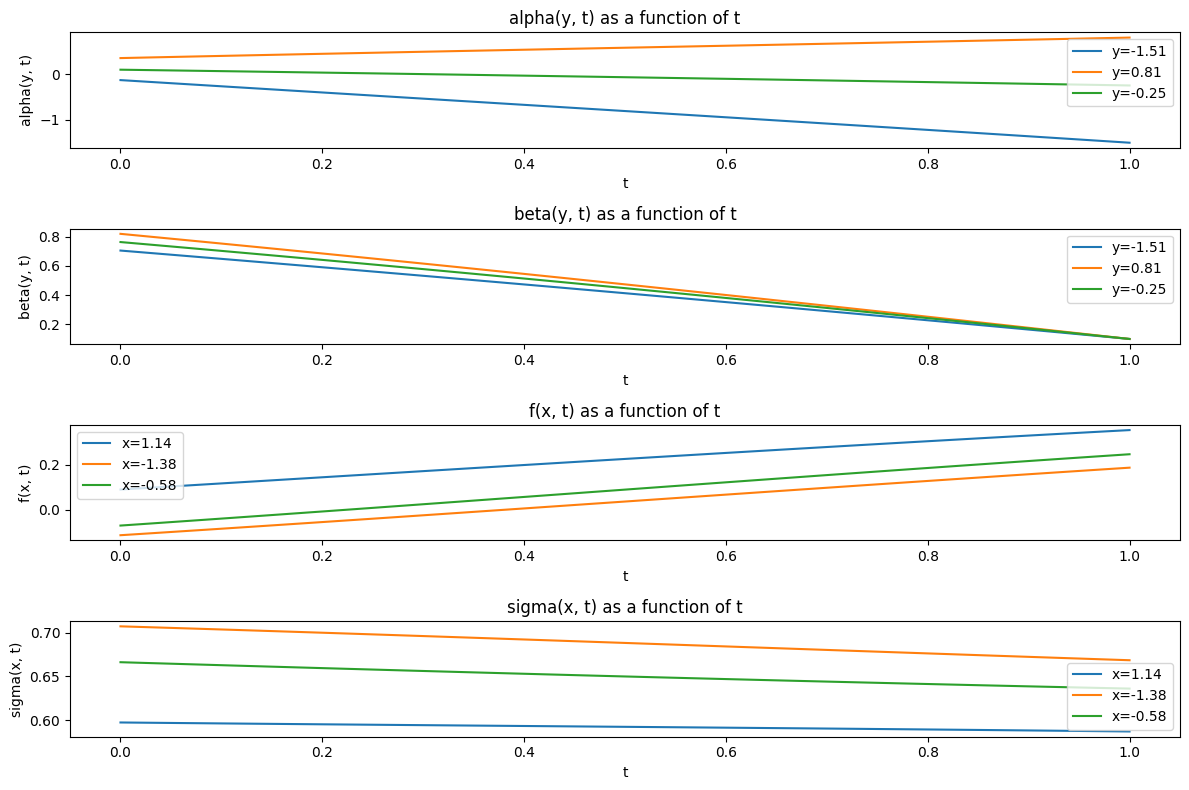

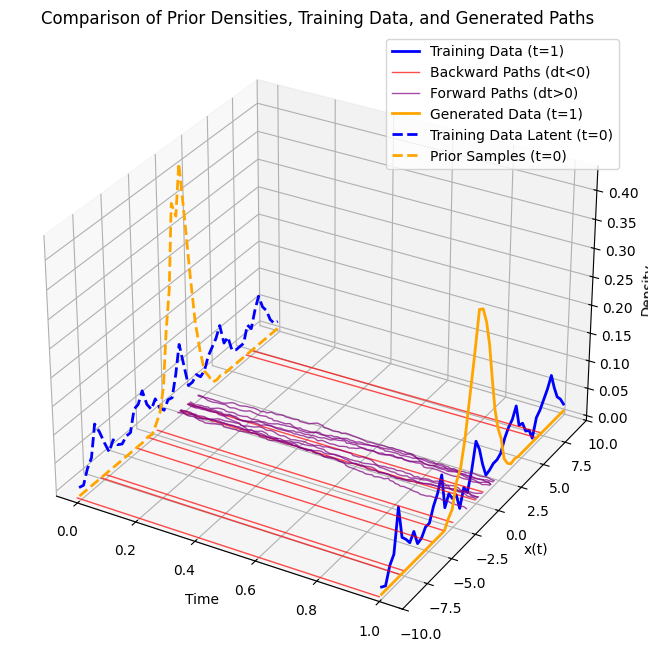

Epoch 0, Log Likelihood: -24.54056477546692 (train), -12.086907386779785 (val)
Epoch 50, Log Likelihood: -3.659784287214279 (train), -3.3308660984039307 (val)
Epoch 100, Log Likelihood: -3.526289999485016 (train), -2.931328773498535 (val)
Epoch 150, Log Likelihood: -3.0130188167095184 (train), -3.307288646697998 (val)
Epoch 200, Log Likelihood: -3.2097441852092743 (train), -3.101623058319092 (val)
Epoch 250, Log Likelihood: -2.8599355220794678 (train), -3.0077126026153564 (val)
Epoch 300, Log Likelihood: -3.1154503226280212 (train), -2.975050687789917 (val)
Epoch 350, Log Likelihood: -3.2290954291820526 (train), -3.1132564544677734 (val)
Epoch 400, Log Likelihood: -3.1791616082191467 (train), -3.1525962352752686 (val)
Epoch 450, Log Likelihood: -2.8889686465263367 (train), -3.065309524536133 (val)
Epoch 500, Log Likelihood: -3.061930686235428 (train), -3.331279754638672 (val)
Epoch 550, Log Likelihood: -2.967678666114807 (train), -2.842496156692505 (val)
Epoch 600, Log Likelihood: -3.0

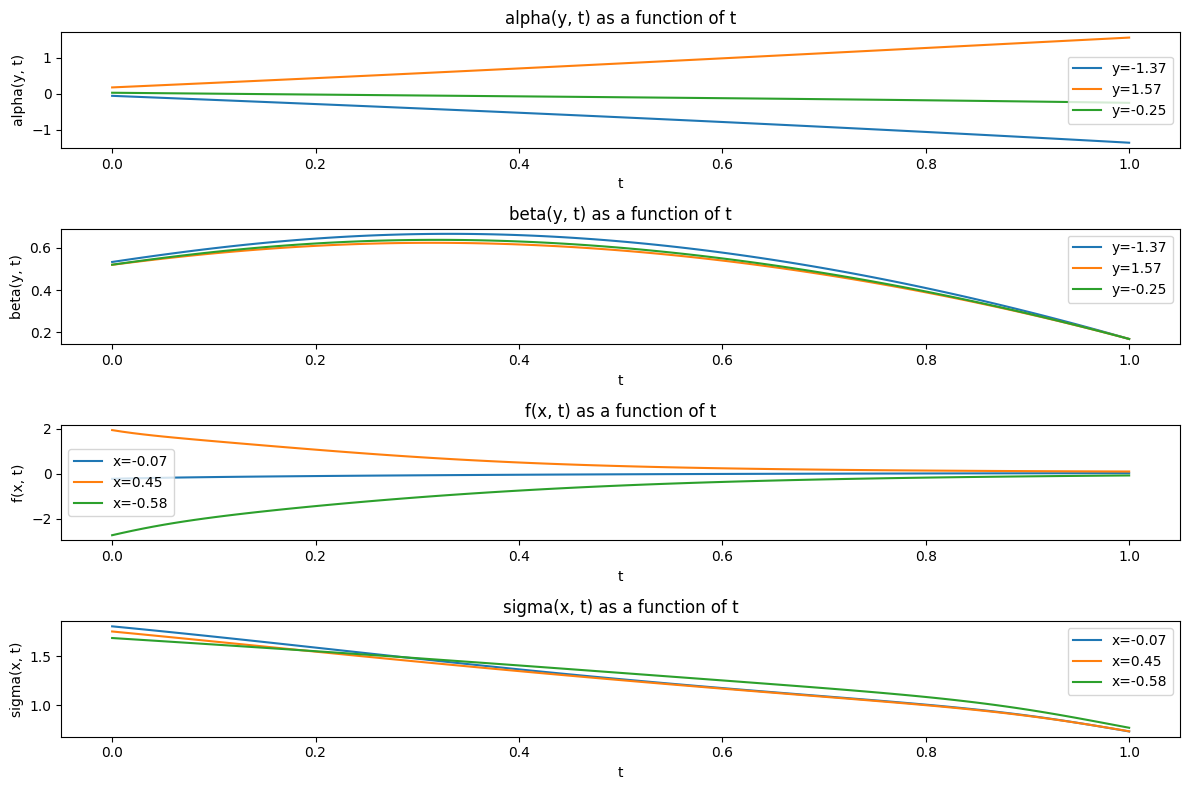

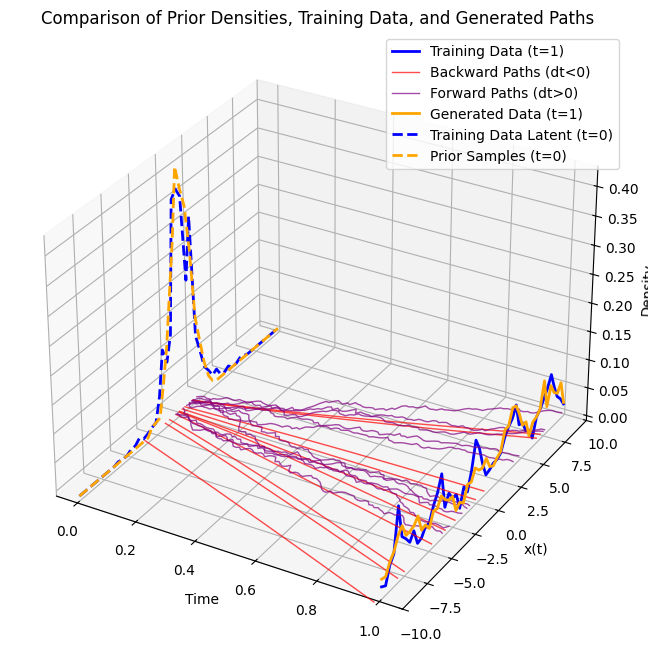

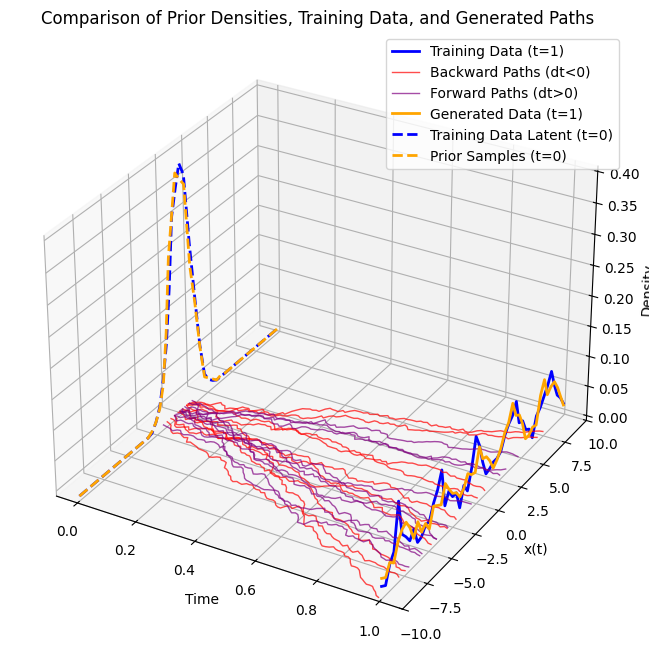

In [14]:
data_loader = torch.utils.data.DataLoader(training_data, batch_size=125, shuffle=True)
set_seed(42)
# Set standard deviation in beta_net and likelihood function to the same parameter values
beta = Beta(initial_beta=1e-1, trainable=True)

# Initialize the networks
f_net = DriftNetwork()
sigma_net = DiffusionNetwork()
alpha_net = AlphaNetwork() # 1()
beta_net = BetaNetwork(beta=beta)

# Plot alpha_net, beta_net, and sigma_net for some samples
plot_alpha_beta_f_sigma(alpha_net, beta_net, f_net, sigma_net, num_samples=3)

# Set the prior (Gaussian or Laplace, as needed) and Likelihood
prior = Prior(gaussian_sample, gaussian_log_pdf)
likelihood_func = Likelihood(beta=beta) # width of gaussian

# time grid
t = torch.linspace(0, 1, steps=100) # SDE discretization only used for visualization

# define path instances
forward_path = ForwardPath(mode="sde", f_net=f_net, sigma_net=sigma_net, prior=prior, likelihood_func=likelihood_func)
backward_path = BackwardPath(mode="ode", f_net=f_net, alpha_net=alpha_net, beta_net=beta_net, sigma_net=sigma_net, likelihood_func=likelihood_func)

# visualize paths and marginals before training
visualize_paths_and_marginals(validation_data, t, backward_path, forward_path)

# Train the SDE
trained_f_net = training_loop_sde(
    f_net, alpha_net, beta_net, sigma_net, prior, likelihood_func, data_loader, validation_data, n_epochs=1000, lr=1e-3
)

# Plot alpha_net, beta_net, and sigma_net for some samples
plot_alpha_beta_f_sigma(alpha_net, beta_net, f_net, sigma_net, num_samples=3)

# visualize paths and marginals after training
visualize_paths_and_marginals(validation_data, t, backward_path, forward_path)
backward_path2 = BackwardPath(mode="backward sde", f_net=f_net, alpha_net=alpha_net, beta_net=beta_net, sigma_net=sigma_net, likelihood_func=likelihood_func)
visualize_paths_and_marginals(validation_data, t, backward_path2, forward_path)